From [[ch6] Modeling](https://www.kaggle.com/code/werooring/ch6-modeling/notebook)

### 6.5~6.7 자전거 대여 수요 예측 경진대회 모델 성능 개선

[자전거 대여 수요 예측 경진대회 링크 - Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand)

[탐색적 데이터 분석 코드 참고 링크 - EDA & Ensemble Model (Top 10 Percentile)](https://www.kaggle.com/code/viveksrinivasan/eda-ensemble-model-top-10-percentile/notebook)

In [2]:
import pandas as pd
# 데이터 경로
data_path = './bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

### 피처 엔지니어링¶

### 이상치 제거

In [3]:
# 훈련 데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather'] != 4]

### 데이터 합치기

In [4]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


### 파생 변수(피처) 추가¶

In [5]:
from datetime import datetime

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])
# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
# 요일 피처 생성
all_data["weekday"] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())

### 필요 없는 피처 제거

In [7]:
drop_features = ['casual', 'registered', 'datetime', 'date', 'windspeed', 'month']

all_data = all_data.drop(drop_features, axis=1)

### 데이터 나누기

In [8]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값

### 평가지표 계산 함수 작성

In [10]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

### 6.5 성능 개선 I : 릿지 회귀 모델

### 6.5.1 하이퍼 파라미터 최적화(모델 훈련)

### 모델 생성

In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

### 그리드서치 객체 생성

In [13]:
# 하이퍼 파라미터 값 목록
ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# 교차 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
# 그리드서치(with 릿지) 객체 생성
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,   # 릿지 모델
                                      param_grid=ridge_params, # 값 목록
                                      scoring=rmsle_scorer,    # 평가지표
                                      cv=5)                    # 교차검증 분할 수

### 그리드서치 수행

In [14]:
log_y = np.log(y) # 타깃값 로그변환
gridsearch_ridge_model.fit(X_train, log_y) # 훈련(그리드서치)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [15]:
print('최적 하이퍼파라미터 :', gridsearch_ridge_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.1, 'max_iter': 3000}


### 6.5.2 성능 검증

In [16]:
# 예측
preds = gridsearch_ridge_model.best_estimator_.predict(X_train) 

# 평가
print(f'릿지 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}') 

릿지 회귀 RMSLE 값 : 1.0205


### 6.6 성능 개선 II : 라쏘 회귀 모델

### 6.6.1 하이퍼 파라미터 최적화(모델 훈련)

In [17]:
from sklearn.linear_model import Lasso

# 모델 생성
lasso_model = Lasso()
# 하이퍼파라미터 값 목록
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}
# 그리드서치(with 라쏘) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.00125, 'max_iter': 3000}


### 6.6.2 성능 검증¶

In [18]:
# 예측
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

# 평가
print(f'라쏘 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

라쏘 회귀 RMSLE 값 : 1.0205


### 6.7 성능 개선 III : 랜덤 포레스트 회귀 모델

### 6.7.1 하이퍼 파라미터 최적화(모델 훈련)

In [19]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
randomforest_model = RandomForestRegressor()
# 그리드서치 객체 생성
rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터 : {'n_estimators': 140, 'random_state': 42}


### 6.7.2 모델 성능 검증

In [20]:
# 예측
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

# 평가
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.1126


### 6.7.3 예측 및 결과 제출

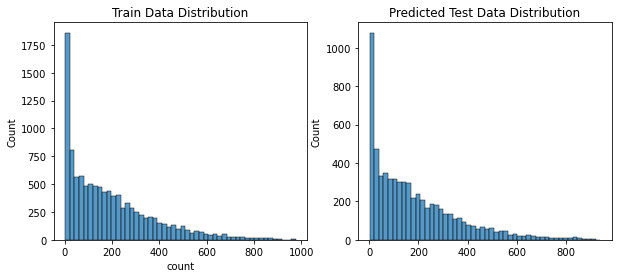

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution');

In [22]:
submission['count'] = np.exp(randomforest_preds) # 지수변환
submission.to_csv('submission.csv', index=False)